EXAMPLE 1: Training and saving a new model
🚀 TRAINING AND SAVING MODEL
🛡️  IMPROVED NETWORK INTRUSION DETECTION SYSTEM
   (With Data Leakage Prevention & Model Persistence)
[*] Loading and analyzing data from 'C:\Users\Prathamesh\Downloads\Data_Science\IDS\dataset\ids_data.csv'...
[+] Dataset loaded: (2214469, 79)
[*] Columns: 79
[*] Rows: 2214469
[*] Cleaning and preprocessing data...
[*] Removed 271598 duplicate rows
[*] Checking for suspicious features...
[*] Top 10 features by correlation with target:
   1. Bwd Packet Length Std: 0.6188
   2. Bwd Packet Length Mean: 0.6132
   3. Avg Bwd Segment Size: 0.6132
   4. Bwd Packet Length Max: 0.6098
   5. Packet Length Std: 0.5808
   6. Max Packet Length: 0.5657
   7. Packet Length Mean: 0.5418
   8. Average Packet Size: 0.5403
   9. Packet Length Variance: 0.5338
  10. Fwd IAT Std: 0.5098

[*] Checking for features with few unique values:
[+] Data preprocessing completed.
[*] Preparing data with validation...
[*] Performing feature selec

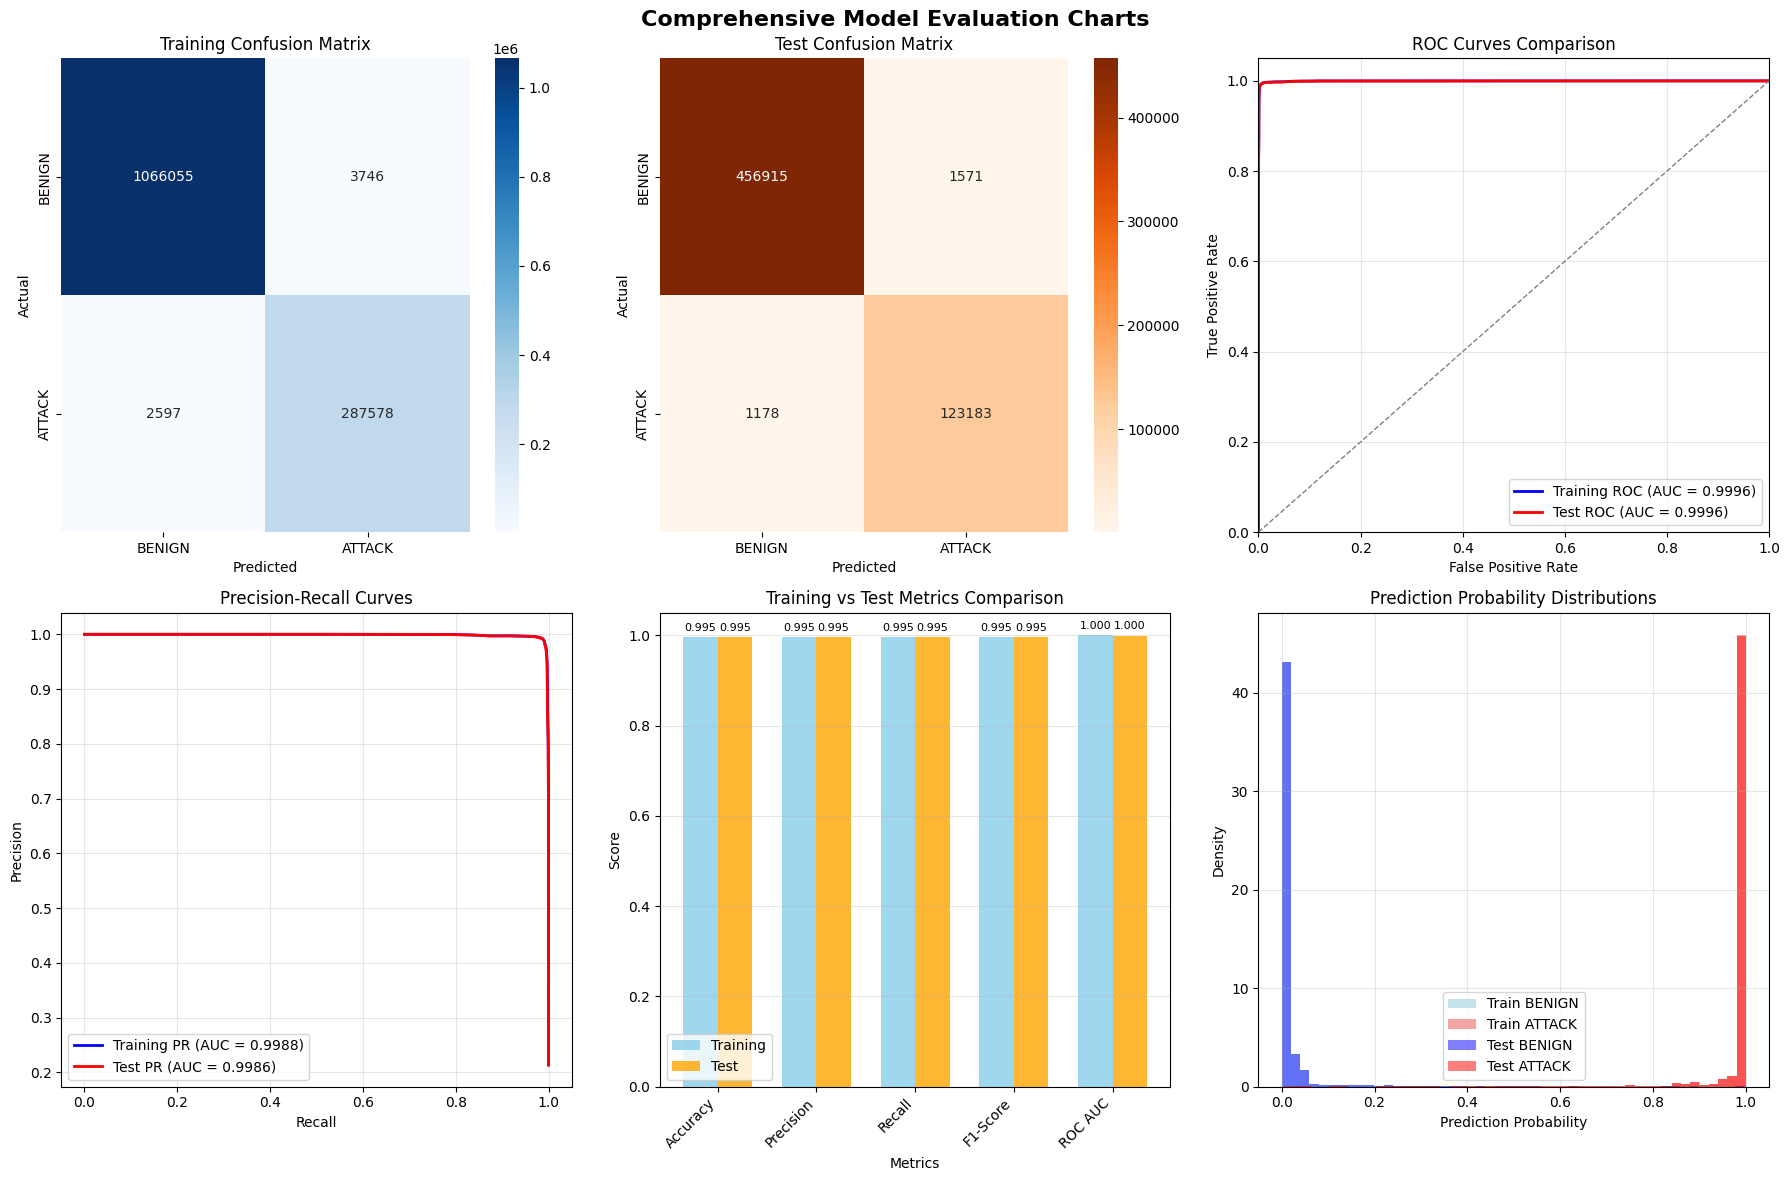


[*] Feature importance analysis...


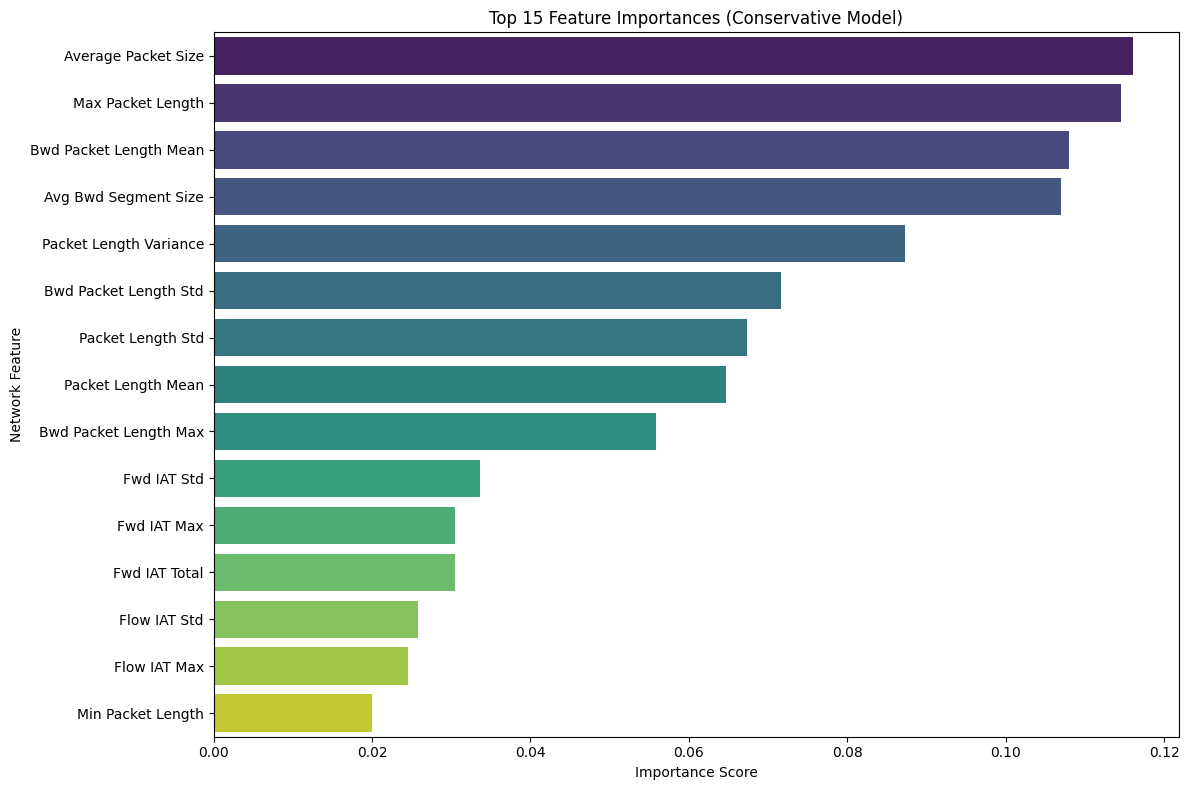


[*] Saving model components to 'C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model'...
[+] Model saved to: C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model\ids_model.pkl
[+] Scaler saved to: C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model\scaler.pkl
[+] Feature selector saved to: C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model\ids_model_feature_selector.pkl
[+] Metadata saved to: C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model\ids_model_metadata.json
[+] Model saving completed successfully!

📋 FINAL SUMMARY REPORT
✅ Training Accuracy: 0.995336
✅ Test Accuracy:     0.995283
✅ Training F1:       0.995339
✅ Test F1:           0.995286
✅ Training ROC AUC:  0.999637
✅ Test ROC AUC:      0.999574
✅ CV Accuracy:       0.995234

[*] Pipeline completed successfully!

🚨 ATTENTION: Perfect or near-perfect scores detected!
🔍 Recommended actions:
   1. Examine dataset for time-based or derived features
   2. Try temporal train/test split
   3. Ver

In [17]:
# Improved Intrusion Detection System with Data Leakage Prevention and Model Persistence
# This version includes additional checks to prevent overfitting and data leakage
# Plus model saving/loading functionality

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             precision_recall_curve, roc_curve, auc)
from sklearn.feature_selection import SelectKBest, f_classif
import joblib  # Added for model persistence
import warnings
import os
import json  # Added for metadata saving
from datetime import datetime

warnings.filterwarnings('ignore')

class ImprovedNetworkIntrusionDetector:
    """
    An improved intrusion detection system with data leakage prevention,
    realistic evaluation metrics, and model persistence capabilities.
    """
    def __init__(self, dataset_path=None, random_state=42):
        self.dataset_path = dataset_path
        self.random_state = random_state
        self.data = None
        self.model = None
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.feature_names = None
        self.selected_features = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4
        self.model_metadata = {}  # Store model information

    def load_and_analyze_data(self):
        """
        Loads the dataset and performs thorough analysis to detect potential issues.
        """
        if self.dataset_path is None:
            print("[!] ERROR: No dataset path provided")
            return False
            
        print(f"[*] Loading and analyzing data from '{self.dataset_path}'...")
        try:
            self.data = pd.read_csv(self.dataset_path, low_memory=False)
        except FileNotFoundError:
            print(f"[!] ERROR: Dataset not found at '{self.dataset_path}'")
            return False

        print(f"[+] Dataset loaded: {self.data.shape}")
        
        # Basic info
        print(f"[*] Columns: {len(self.data.columns)}")
        print(f"[*] Rows: {len(self.data)}")
        
        # Check for label distribution
        if 'Label' in self.data.columns:
            print(f"[*] Label distribution:")
            label_counts = self.data['Label'].value_counts()
            print(label_counts)
            
            # Check for severely imbalanced classes
            min_class_size = label_counts.min()
            max_class_size = label_counts.max()
            imbalance_ratio = max_class_size / min_class_size
            print(f"[*] Imbalance ratio: {imbalance_ratio:.2f}")
            
            if imbalance_ratio > 1000:
                print("[!] WARNING: Severe class imbalance detected!")
        
        return True

    def clean_and_preprocess_data(self):
        """
        Enhanced data cleaning with additional checks for data leakage.
        """
        print("[*] Cleaning and preprocessing data...")
        
        # Clean column names
        self.data.columns = self.data.columns.str.strip()
        
        # Handle infinite values
        self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Check for duplicate rows (more thorough check)
        initial_rows = len(self.data)
        self.data.drop_duplicates(inplace=True)
        removed_duplicates = initial_rows - len(self.data)
        print(f"[*] Removed {removed_duplicates} duplicate rows")
        
        # Drop rows where the label is missing
        self.data.dropna(subset=['Label'], inplace=True)
        
        # Remove classes with very few samples
        label_counts = self.data['Label'].value_counts()
        labels_to_keep = label_counts[label_counts >= 100].index
        self.data = self.data[self.data['Label'].isin(labels_to_keep)]
        
        # Check for potentially problematic features
        self.check_suspicious_features()
        
        print("[+] Data preprocessing completed.")
        return True

    def check_suspicious_features(self):
        """
        Identifies features that might cause data leakage.
        """
        print("[*] Checking for suspicious features...")
        
        # Look for features with very high correlation with the target
        # First, create binary labels
        temp_labels = self.data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
        
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        correlations = {}
        
        for col in numeric_cols:
            if col != 'Label':
                # Handle NaN values
                temp_data = self.data[col].fillna(0)
                try:
                    corr = np.corrcoef(temp_data, temp_labels)[0, 1]
                    if not np.isnan(corr):
                        correlations[col] = abs(corr)
                except:
                    pass
        
        # Sort by correlation
        sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
        
        print("[*] Top 10 features by correlation with target:")
        for i, (feature, corr) in enumerate(sorted_corr[:10]):
            print(f"  {i+1:2d}. {feature}: {corr:.4f}")
            if corr > 0.99:
                print(f"      [!] WARNING: Extremely high correlation!")
        
        # Check for features with very few unique values
        print("\n[*] Checking for features with few unique values:")
        for col in numeric_cols[:10]:  # Check first 10 numeric columns
            unique_vals = self.data[col].nunique()
            if unique_vals <= 2:
                print(f"  {col}: {unique_vals} unique values")

    def prepare_data_with_validation(self):
        """
        Prepares data with additional validation steps to prevent overfitting.
        """
        print("[*] Preparing data with validation...")
        
        # Binarize labels
        self.data['Label'] = self.data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
        
        X = self.data.drop(columns=['Label'])
        y = self.data['Label']
        
        # Ensure all features are numeric
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        X.fillna(0, inplace=True)
        
        # Feature selection to reduce overfitting
        print("[*] Performing feature selection...")
        self.feature_selector = SelectKBest(score_func=f_classif, k=min(20, len(X.columns)))
        X_selected = self.feature_selector.fit_transform(X, y)
        self.selected_features = X.columns[self.feature_selector.get_support()]
        print(f"[*] Selected {len(self.selected_features)} features out of {len(X.columns)}")
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_selected, y, test_size=0.3, random_state=self.random_state, stratify=y
        )
        
        # Scale the data
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
        print(f"[*] Training samples: {self.X_train.shape[0]}")
        print(f"[*] Testing samples: {self.X_test.shape[0]}")
        print(f"[*] Class distribution in training: {np.bincount(self.y_train)}")

    def train_conservative_model(self):
        """
        Trains a more conservative model to prevent overfitting.
        """
        print("[*] Training conservative RandomForest model...")
        
        # Use more conservative hyperparameters
        self.model = RandomForestClassifier(
            n_estimators=50,  # Reduced from 100
            max_depth=10,     # Limited depth to prevent overfitting
            min_samples_split=20,  # Higher minimum samples
            min_samples_leaf=10,   # Higher minimum leaf samples
            random_state=self.random_state,
            n_jobs=-1,
            class_weight='balanced'
        )
        
        self.model.fit(self.X_train, self.y_train)
        
        # Store model metadata
        self.model_metadata = {
            'training_date': datetime.now().isoformat(),
            'model_type': 'RandomForestClassifier',
            'n_features': len(self.selected_features),
            'selected_features': list(self.selected_features),
            'training_samples': self.X_train.shape[0],
            'test_samples': self.X_test.shape[0],
            'random_state': self.random_state,
            'hyperparameters': {
                'n_estimators': 50,
                'max_depth': 10,
                'min_samples_split': 20,
                'min_samples_leaf': 10,
                'class_weight': 'balanced'
            }
        }
        
        print("[+] Model training completed.")

    def save_model(self, model_dir=r'C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model', model_name='ids_model'):
        """
        Saves the trained model, scaler, feature selector, and metadata to disk.
        
        Parameters:
        -----------
        model_dir : str
            Directory to save the model files
        model_name : str
            Base name for the model files
        """
        if self.model is None:
            print("[!] ERROR: No trained model to save. Please train the model first.")
            return False
        
        print(f"\n[*] Saving model components to '{model_dir}'...")
        
        # Create directory if it doesn't exist
        os.makedirs(model_dir, exist_ok=True)
        
        try:
            # Define file paths - using your specific naming convention
            model_path = os.path.join(model_dir, f'{model_name}.pkl')
            scaler_path = os.path.join(model_dir, 'scaler.pkl')  # Using your exact filename
            feature_selector_path = os.path.join(model_dir, f'{model_name}_feature_selector.pkl')
            metadata_path = os.path.join(model_dir, f'{model_name}_metadata.json')
            
            # Save model components
            joblib.dump(self.model, model_path)
            joblib.dump(self.scaler, scaler_path)
            joblib.dump(self.feature_selector, feature_selector_path)
            
            # Save metadata
            with open(metadata_path, 'w') as f:
                json.dump(self.model_metadata, f, indent=2)
            
            print(f"[+] Model saved to: {model_path}")
            print(f"[+] Scaler saved to: {scaler_path}")
            print(f"[+] Feature selector saved to: {feature_selector_path}")
            print(f"[+] Metadata saved to: {metadata_path}")
            print(f"[+] Model saving completed successfully!")
            
            return True
            
        except Exception as e:
            print(f"[!] ERROR: Failed to save model - {str(e)}")
            return False

    def load_model(self, model_dir=r'C:\Users\Prathamesh\Downloads\Data_Science\IDS\saved_model', model_name='ids_model'):
        """
        Loads a previously trained model, scaler, feature selector, and metadata from disk.
        
        Parameters:
        -----------
        model_dir : str
            Directory containing the model files
        model_name : str
            Base name for the model files
        """
        print(f"\n[*] Loading model components from '{model_dir}'...")
        
        try:
            # Define file paths
            model_path = os.path.join(model_dir, f'{model_name}.pkl')
            scaler_path = os.path.join(model_dir, f'{model_name}_scaler.pkl')
            feature_selector_path = os.path.join(model_dir, f'{model_name}_feature_selector.pkl')
            metadata_path = os.path.join(model_dir, f'{model_name}_metadata.json')
            
            # Check if all files exist
            required_files = [model_path, scaler_path, feature_selector_path, metadata_path]
            missing_files = [f for f in required_files if not os.path.exists(f)]
            
            if missing_files:
                print(f"[!] ERROR: Missing model files: {missing_files}")
                return False
            
            # Load model components
            self.model = joblib.load(model_path)
            self.scaler = joblib.load(scaler_path)
            self.feature_selector = joblib.load(feature_selector_path)
            
            # Load metadata
            with open(metadata_path, 'r') as f:
                self.model_metadata = json.load(f)
            
            # Restore selected features
            self.selected_features = pd.Index(self.model_metadata['selected_features'])
            
            print(f"[+] Model loaded from: {model_path}")
            print(f"[+] Scaler loaded from: {scaler_path}")
            print(f"[+] Feature selector loaded from: {feature_selector_path}")
            print(f"[+] Metadata loaded from: {metadata_path}")
            print(f"[+] Model trained on: {self.model_metadata['training_date']}")
            print(f"[+] Number of features: {self.model_metadata['n_features']}")
            print(f"[+] Model loading completed successfully!")
            
            return True
            
        except Exception as e:
            print(f"[!] ERROR: Failed to load model - {str(e)}")
            return False

    def predict_new_data(self, new_data):
        """
        Makes predictions on new data using the loaded model.
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data to make predictions on
            
        Returns:
        --------
        predictions : array
            Binary predictions (0 = BENIGN, 1 = ATTACK)
        probabilities : array
            Prediction probabilities for the positive class
        """
        if self.model is None:
            print("[!] ERROR: No model loaded. Please load a model first.")
            return None, None
        
        print(f"[*] Making predictions on {len(new_data)} samples...")
        
        try:
            # Ensure all features are numeric and fill missing values
            for col in new_data.columns:
                new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
            new_data.fillna(0, inplace=True)
            
            # Apply feature selection
            new_data_selected = self.feature_selector.transform(new_data)
            
            # Scale the data
            new_data_scaled = self.scaler.transform(new_data_selected)
            
            # Make predictions
            predictions = self.model.predict(new_data_scaled)
            probabilities = self.model.predict_proba(new_data_scaled)[:, 1]
            
            print(f"[+] Predictions completed!")
            print(f"[*] Detected {sum(predictions)} attacks out of {len(predictions)} samples")
            
            return predictions, probabilities
            
        except Exception as e:
            print(f"[!] ERROR: Failed to make predictions - {str(e)}")
            return None, None

    def get_model_info(self):
        """
        Displays information about the loaded model.
        """
        if not self.model_metadata:
            print("[!] No model metadata available.")
            return
        
        print("\n" + "="*60)
        print("📋 MODEL INFORMATION")
        print("="*60)
        print(f"Model Type:        {self.model_metadata.get('model_type', 'Unknown')}")
        print(f"Training Date:     {self.model_metadata.get('training_date', 'Unknown')}")
        print(f"Number of Features: {self.model_metadata.get('n_features', 'Unknown')}")
        print(f"Training Samples:  {self.model_metadata.get('training_samples', 'Unknown')}")
        print(f"Test Samples:      {self.model_metadata.get('test_samples', 'Unknown')}")
        print(f"Random State:      {self.model_metadata.get('random_state', 'Unknown')}")
        
        if 'hyperparameters' in self.model_metadata:
            print("\nHyperparameters:")
            for param, value in self.model_metadata['hyperparameters'].items():
                print(f"  {param}: {value}")
        
        if 'selected_features' in self.model_metadata:
            print(f"\nSelected Features ({len(self.model_metadata['selected_features'])}):")
            for i, feature in enumerate(self.model_metadata['selected_features'], 1):
                print(f"  {i:2d}. {feature}")
        
        print("="*60)

    def comprehensive_evaluation(self):
        """
        Performs comprehensive evaluation with detailed metrics for both training and testing sets.
        """
        if self.model is None:
            print("[!] Model not trained yet.")
            return
        
        print("\n" + "="*80)
        print("🔍 COMPREHENSIVE MODEL EVALUATION WITH DETAILED METRICS")
        print("="*80)
        
        # Get predictions for both training and test sets
        train_predictions = self.model.predict(self.X_train)
        train_probabilities = self.model.predict_proba(self.X_train)[:, 1]
        
        test_predictions = self.model.predict(self.X_test)
        test_probabilities = self.model.predict_proba(self.X_test)[:, 1]
        
        # =================================================================
        # TRAINING SET EVALUATION
        # =================================================================
        print("\n🏋️  TRAINING SET PERFORMANCE")
        print("="*50)
        
        train_accuracy = accuracy_score(self.y_train, train_predictions)
        train_precision = precision_score(self.y_train, train_predictions, average='weighted')
        train_recall = recall_score(self.y_train, train_predictions, average='weighted')
        train_f1 = f1_score(self.y_train, train_predictions, average='weighted')
        train_roc_auc = roc_auc_score(self.y_train, train_probabilities)
        
        # Per-class metrics for training
        train_precision_per_class = precision_score(self.y_train, train_predictions, average=None)
        train_recall_per_class = recall_score(self.y_train, train_predictions, average=None)
        train_f1_per_class = f1_score(self.y_train, train_predictions, average=None)
        
        print(f"📊 OVERALL TRAINING METRICS:")
        print(f"   ✓ Accuracy:     {train_accuracy:.6f}")
        print(f"   ✓ Precision:    {train_precision:.6f}")
        print(f"   ✓ Recall:       {train_recall:.6f}")
        print(f"   ✓ F1-Score:     {train_f1:.6f}")
        print(f"   ✓ ROC AUC:      {train_roc_auc:.6f}")
        
        print(f"\n📈 PER-CLASS TRAINING METRICS:")
        print(f"   BENIGN  (Class 0): Precision={train_precision_per_class[0]:.6f}, Recall={train_recall_per_class[0]:.6f}, F1={train_f1_per_class[0]:.6f}")
        print(f"   ATTACK  (Class 1): Precision={train_precision_per_class[1]:.6f}, Recall={train_recall_per_class[1]:.6f}, F1={train_f1_per_class[1]:.6f}")
        
        # Training Confusion Matrix
        train_cm = confusion_matrix(self.y_train, train_predictions)
        print(f"\n📋 TRAINING CONFUSION MATRIX:")
        print(f"              Predicted")
        print(f"              BENIGN  ATTACK")
        print(f"   BENIGN     {train_cm[0,0]:6d}  {train_cm[0,1]:6d}")
        print(f"   ATTACK     {train_cm[1,0]:6d}  {train_cm[1,1]:6d}")
        
        # =================================================================
        # TEST SET EVALUATION
        # =================================================================
        print("\n🧪 TEST SET PERFORMANCE")
        print("="*50)
        
        test_accuracy = accuracy_score(self.y_test, test_predictions)
        test_precision = precision_score(self.y_test, test_predictions, average='weighted')
        test_recall = recall_score(self.y_test, test_predictions, average='weighted')
        test_f1 = f1_score(self.y_test, test_predictions, average='weighted')
        test_roc_auc = roc_auc_score(self.y_test, test_probabilities)
        
        # Per-class metrics for test
        test_precision_per_class = precision_score(self.y_test, test_predictions, average=None)
        test_recall_per_class = recall_score(self.y_test, test_predictions, average=None)
        test_f1_per_class = f1_score(self.y_test, test_predictions, average=None)
        
        print(f"📊 OVERALL TEST METRICS:")
        print(f"   ✓ Accuracy:     {test_accuracy:.6f}")
        print(f"   ✓ Precision:    {test_precision:.6f}")
        print(f"   ✓ Recall:       {test_recall:.6f}")
        print(f"   ✓ F1-Score:     {test_f1:.6f}")
        print(f"   ✓ ROC AUC:      {test_roc_auc:.6f}")
        
        print(f"\n📈 PER-CLASS TEST METRICS:")
        print(f"   BENIGN  (Class 0): Precision={test_precision_per_class[0]:.6f}, Recall={test_recall_per_class[0]:.6f}, F1={test_f1_per_class[0]:.6f}")
        print(f"   ATTACK  (Class 1): Precision={test_precision_per_class[1]:.6f}, Recall={test_recall_per_class[1]:.6f}, F1={test_f1_per_class[1]:.6f}")
        
        # Test Confusion Matrix
        test_cm = confusion_matrix(self.y_test, test_predictions)
        print(f"\n📋 TEST CONFUSION MATRIX:")
        print(f"              Predicted")
        print(f"              BENIGN  ATTACK")
        print(f"   BENIGN     {test_cm[0,0]:6d}  {test_cm[0,1]:6d}")
        print(f"   ATTACK     {test_cm[1,0]:6d}  {test_cm[1,1]:6d}")
        
        # =================================================================
        # PERFORMANCE COMPARISON & OVERFITTING ANALYSIS
        # =================================================================
        print("\n🔍 OVERFITTING ANALYSIS")
        print("="*50)
        
        accuracy_diff = train_accuracy - test_accuracy
        f1_diff = train_f1 - test_f1
        roc_diff = train_roc_auc - test_roc_auc
        
        print(f"📉 PERFORMANCE GAPS (Training - Test):")
        print(f"   Accuracy Gap:   {accuracy_diff:+.6f}")
        print(f"   F1-Score Gap:   {f1_diff:+.6f}")
        print(f"   ROC AUC Gap:    {roc_diff:+.6f}")
        
        # Overfitting warnings
        if accuracy_diff > 0.05:
            print(f"   ⚠️  WARNING: Significant accuracy gap detected!")
        if f1_diff > 0.05:
            print(f"   ⚠️  WARNING: Significant F1-score gap detected!")
        if roc_diff > 0.05:
            print(f"   ⚠️  WARNING: Significant ROC AUC gap detected!")
            
        # Perfect score warnings
        if test_roc_auc > 0.999:
            print(f"\n   🚨 CRITICAL WARNING: Test ROC AUC > 0.999!")
            print(f"   🚨 This strongly suggests data leakage or overfitting!")
        elif test_accuracy > 0.999:
            print(f"\n   ⚠️  WARNING: Test accuracy > 99.9%!")
            print(f"   ⚠️  Results may be unrealistic - check for data leakage!")
        
        # =================================================================
        # CROSS-VALIDATION ANALYSIS
        # =================================================================
        print("\n🔄 CROSS-VALIDATION ANALYSIS")
        print("="*50)
        
        # Multiple CV metrics
        cv_accuracy = cross_val_score(self.model, self.X_train, self.y_train, 
                                     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state),
                                     scoring='accuracy')
        cv_f1 = cross_val_score(self.model, self.X_train, self.y_train, 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state),
                               scoring='f1_weighted')
        cv_roc = cross_val_score(self.model, self.X_train, self.y_train, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state),
                                scoring='roc_auc')
        
        print(f"📊 5-FOLD CROSS-VALIDATION RESULTS:")
        print(f"   CV Accuracy:  {cv_accuracy.mean():.6f} (±{cv_accuracy.std()*2:.6f})")
        print(f"   CV F1-Score:  {cv_f1.mean():.6f} (±{cv_f1.std()*2:.6f})")
        print(f"   CV ROC AUC:   {cv_roc.mean():.6f} (±{cv_roc.std()*2:.6f})")
        
        # =================================================================
        # DETAILED CLASSIFICATION REPORT
        # =================================================================
        print("\n📋 DETAILED CLASSIFICATION REPORT (TEST SET)")
        print("="*60)
        print(classification_report(self.y_test, test_predictions, 
                                  target_names=['BENIGN', 'ATTACK'], 
                                  digits=6))
        
        # Store metrics in metadata for saving
        self.model_metadata.update({
            'evaluation_metrics': {
                'train': {
                    'accuracy': train_accuracy, 'precision': train_precision,
                    'recall': train_recall, 'f1': train_f1, 'roc_auc': train_roc_auc
                },
                'test': {
                    'accuracy': test_accuracy, 'precision': test_precision,
                    'recall': test_recall, 'f1': test_f1, 'roc_auc': test_roc_auc
                },
                'cv': {
                    'accuracy': cv_accuracy.mean(), 'f1': cv_f1.mean(), 'roc_auc': cv_roc.mean()
                }
            }
        })
        
        # =================================================================
        # VISUALIZATION
        # =================================================================
        self.plot_detailed_evaluation_charts(self.y_train, train_predictions, train_probabilities,
                                            self.y_test, test_predictions, test_probabilities)
        
        # Return metrics dictionary for further analysis
        return {
            'train': {
                'accuracy': train_accuracy, 'precision': train_precision,
                'recall': train_recall, 'f1': train_f1, 'roc_auc': train_roc_auc
            },
            'test': {
                'accuracy': test_accuracy, 'precision': test_precision,
                'recall': test_recall, 'f1': test_f1, 'roc_auc': test_roc_auc
            },
            'cv': {
                'accuracy': cv_accuracy.mean(), 'f1': cv_f1.mean(), 'roc_auc': cv_roc.mean()
            }
        }

    def plot_detailed_evaluation_charts(self, y_train, train_pred, train_prob, y_test, test_pred, test_prob):
        """
        Creates comprehensive visualization charts for model evaluation.
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Comprehensive Model Evaluation Charts', fontsize=16, fontweight='bold')
        
        # 1. Training Confusion Matrix
        train_cm = confusion_matrix(y_train, train_pred)
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                   xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
        axes[0,0].set_title('Training Confusion Matrix')
        axes[0,0].set_ylabel('Actual')
        axes[0,0].set_xlabel('Predicted')
        
        # 2. Test Confusion Matrix
        test_cm = confusion_matrix(y_test, test_pred)
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0,1],
                   xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
        axes[0,1].set_title('Test Confusion Matrix')
        axes[0,1].set_ylabel('Actual')
        axes[0,1].set_xlabel('Predicted')
        
        # 3. ROC Curves Comparison
        train_fpr, train_tpr, _ = roc_curve(y_train, train_prob)
        test_fpr, test_tpr, _ = roc_curve(y_test, test_prob)
        train_roc_auc = auc(train_fpr, train_tpr)
        test_roc_auc = auc(test_fpr, test_tpr)
        
        axes[0,2].plot(train_fpr, train_tpr, color='blue', lw=2, 
                      label=f'Training ROC (AUC = {train_roc_auc:.4f})')
        axes[0,2].plot(test_fpr, test_tpr, color='red', lw=2, 
                      label=f'Test ROC (AUC = {test_roc_auc:.4f})')
        axes[0,2].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        axes[0,2].set_xlim([0.0, 1.0])
        axes[0,2].set_ylim([0.0, 1.05])
        axes[0,2].set_xlabel('False Positive Rate')
        axes[0,2].set_ylabel('True Positive Rate')
        axes[0,2].set_title('ROC Curves Comparison')
        axes[0,2].legend(loc="lower right")
        axes[0,2].grid(True, alpha=0.3)
        
        # 4. Precision-Recall Curves
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_prob)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_prob)
        train_pr_auc = auc(train_recall, train_precision)
        test_pr_auc = auc(test_recall, test_precision)
        
        axes[1,0].plot(train_recall, train_precision, color='blue', lw=2,
                      label=f'Training PR (AUC = {train_pr_auc:.4f})')
        axes[1,0].plot(test_recall, test_precision, color='red', lw=2,
                      label=f'Test PR (AUC = {test_pr_auc:.4f})')
        axes[1,0].set_xlabel('Recall')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].set_title('Precision-Recall Curves')
        axes[1,0].legend(loc="lower left")
        axes[1,0].grid(True, alpha=0.3)
        
        # 5. Metrics Comparison Bar Chart
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
        train_values = [
            accuracy_score(y_train, train_pred),
            precision_score(y_train, train_pred, average='weighted'),
            recall_score(y_train, train_pred, average='weighted'),
            f1_score(y_train, train_pred, average='weighted'),
            roc_auc_score(y_train, train_prob)
        ]
        test_values = [
            accuracy_score(y_test, test_pred),
            precision_score(y_test, test_pred, average='weighted'),
            recall_score(y_test, test_pred, average='weighted'),
            f1_score(y_test, test_pred, average='weighted'),
            roc_auc_score(y_test, test_prob)
        ]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = axes[1,1].bar(x - width/2, train_values, width, label='Training', color='skyblue', alpha=0.8)
        bars2 = axes[1,1].bar(x + width/2, test_values, width, label='Test', color='orange', alpha=0.8)
        
        axes[1,1].set_xlabel('Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_title('Training vs Test Metrics Comparison')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(metrics, rotation=45, ha='right')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3, axis='y')
        axes[1,1].set_ylim([0, 1.05])
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            axes[1,1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                              xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        for bar in bars2:
            height = bar.get_height()
            axes[1,1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                              xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        
        # 6. Prediction Probability Distribution
        axes[1,2].hist(train_prob[y_train == 0], bins=50, alpha=0.7, label='Train BENIGN', color='lightblue', density=True)
        axes[1,2].hist(train_prob[y_train == 1], bins=50, alpha=0.7, label='Train ATTACK', color='lightcoral', density=True)
        axes[1,2].hist(test_prob[y_test == 0], bins=50, alpha=0.5, label='Test BENIGN', color='blue', density=True)
        axes[1,2].hist(test_prob[y_test == 1], bins=50, alpha=0.5, label='Test ATTACK', color='red', density=True)
        axes[1,2].set_xlabel('Prediction Probability')
        axes[1,2].set_ylabel('Density')
        axes[1,2].set_title('Prediction Probability Distributions')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('comprehensive_evaluation_charts.png', dpi=150, bbox_inches='tight')
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """
        Plots feature importance with additional analysis.
        """
        if self.model is None:
            print("[!] Model not trained yet.")
            return
        
        print(f"\n[*] Feature importance analysis...")
        
        importances = self.model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.selected_features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Check for overly dominant features
        max_importance = feature_importance_df['importance'].max()
        if max_importance > 0.5:
            print(f"[!] WARNING: Feature '{feature_importance_df.iloc[0]['feature']}' has very high importance ({max_importance:.3f})")
            print("[!] This might indicate data leakage!")
        
        # Plot
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(top_n)
        sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
        plt.title(f'Top {top_n} Feature Importances (Conservative Model)')
        plt.xlabel('Importance Score')
        plt.ylabel('Network Feature')
        plt.tight_layout()
        plt.savefig('improved_feature_importance.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        return feature_importance_df

    def run_improved_pipeline(self):
        """
        Runs the improved pipeline with comprehensive checks.
        """
        print("="*70)
        print("🛡️  IMPROVED NETWORK INTRUSION DETECTION SYSTEM")
        print("   (With Data Leakage Prevention & Model Persistence)")
        print("="*70)
        
        if self.load_and_analyze_data():
            if self.clean_and_preprocess_data():
                self.prepare_data_with_validation()
                self.train_conservative_model()
                metrics = self.comprehensive_evaluation()
                importance_df = self.plot_feature_importance()
                
                # Save the trained model
                self.save_model()
                
                print("\n" + "="*80)
                print("📋 FINAL SUMMARY REPORT")
                print("="*80)
                print(f"✅ Training Accuracy: {metrics['train']['accuracy']:.6f}")
                print(f"✅ Test Accuracy:     {metrics['test']['accuracy']:.6f}")
                print(f"✅ Training F1:       {metrics['train']['f1']:.6f}")
                print(f"✅ Test F1:           {metrics['test']['f1']:.6f}")
                print(f"✅ Training ROC AUC:  {metrics['train']['roc_auc']:.6f}")
                print(f"✅ Test ROC AUC:      {metrics['test']['roc_auc']:.6f}")
                print(f"✅ CV Accuracy:       {metrics['cv']['accuracy']:.6f}")
                print("="*80)
                
                print("\n[*] Pipeline completed successfully!")
                if metrics['test']['roc_auc'] > 0.999:
                    print("\n🚨 ATTENTION: Perfect or near-perfect scores detected!")
                    print("🔍 Recommended actions:")
                    print("   1. Examine dataset for time-based or derived features")
                    print("   2. Try temporal train/test split")
                    print("   3. Verify feature engineering pipeline")
                    
                return metrics, importance_df
        
        return None, None


# Example usage functions
def train_and_save_model(dataset_path):
    """
    Example function to train and save a model.
    """
    print("🚀 TRAINING AND SAVING MODEL")
    print("="*50)
    
    detector = ImprovedNetworkIntrusionDetector(dataset_path=dataset_path, random_state=42)
    metrics, importance_df = detector.run_improved_pipeline()
    
    if metrics:
        print("\n✅ Model training and saving completed!")
        return detector
    else:
        print("\n❌ Model training failed!")
        return None


def load_and_predict(model_dir='saved_model', model_name='ids_model', new_data_path=None):
    """
    Example function to load a model and make predictions.
    """
    print("🔮 LOADING MODEL AND MAKING PREDICTIONS")
    print("="*50)
    
    detector = ImprovedNetworkIntrusionDetector()
    
    if detector.load_model(model_dir, model_name):
        detector.get_model_info()
        
        if new_data_path:
            # Load new data for prediction
            print(f"\n[*] Loading new data from: {new_data_path}")
            new_data = pd.read_csv(new_data_path)
            
            # Make predictions
            predictions, probabilities = detector.predict_new_data(new_data)
            
            if predictions is not None:
                # Display results
                results_df = pd.DataFrame({
                    'Prediction': predictions,
                    'Attack_Probability': probabilities,
                    'Classification': ['BENIGN' if p == 0 else 'ATTACK' for p in predictions]
                })
                
                print("\n📊 PREDICTION RESULTS:")
                print(results_df.head(10))
                print(f"\nSummary: {sum(predictions)} attacks detected out of {len(predictions)} samples")
                
                return predictions, probabilities
        else:
            print("[*] No new data provided for prediction.")
            
    return None, None


if __name__ == "__main__":
    # Update this path to your dataset file
    DATASET_PATH = r'C:\Users\Prathamesh\Downloads\Data_Science\IDS\dataset\ids_data.csv'
    
    # Example 1: Train and save a new model
    print("EXAMPLE 1: Training and saving a new model")
    detector = train_and_save_model(DATASET_PATH)
    
    print("\n" + "="*70)
    
    # Example 2: Load the saved model and get info
    print("EXAMPLE 2: Loading saved model and displaying info")
    detector2 = ImprovedNetworkIntrusionDetector()
    if detector2.load_model():
        detector2.get_model_info()
    
    print("\n" + "="*70)
    
    # Example 3: Use loaded model for predictions (if you have new data)
    # Uncomment the following lines if you have new data to predict
    # print("EXAMPLE 3: Making predictions with loaded model")
    # NEW_DATA_PATH = 'path/to/your/new_data.csv'
    # predictions, probabilities = load_and_predict(new_data_path=NEW_DATA_PATH)